# K2 double-counting estimate

Kepler double counts overlapping TPFs in its telemetry, meaning we double-pay for TPFs that have overlapping apertures.  Let's estimate how much of an effect this is.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.utils.console import ProgressBar
import logging
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import astropy.visualization
from fast_histogram import histogram1d

In [4]:
df = pd.read_csv('../../k2-target-index/k2-target-pixel-files.csv.gz')

In [5]:
campaigns = df.campaign.unique()

In [6]:
campaigns

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  91,  92, 101, 102,
       111, 112,  12,  13])

Some of my campaigns failed to count TPFs properly for an as-yet-unknown reason.  Let's skip the campaigns that didn't work for now.  You can spot check which ones worked just by seeing if any pixels were counted.  The "bad" campaigns have zero TPFs matched up.  

In [7]:
! ls ../data/FFI_counts/

C0_FFI_mask.fits   C13_FFI_mask.fits  C3_FFI_mask.fits   C7_FFI_mask.fits
C101_FFI_mask.fits C14_FFI_mask.fits  C4_FFI_mask.fits   C8_FFI_mask.fits
C102_FFI_mask.fits C1_FFI_mask.fits   C5_FFI_mask.fits   C91_FFI_mask.fits
C12_FFI_mask.fits  C2_FFI_mask.fits   C6_FFI_mask.fits   C92_FFI_mask.fits


In [8]:
campaign = 5
hdu_counts = fits.open('../data/FFI_counts/C{}_FFI_mask.fits'.format(str(campaign)))

In [9]:
#for i in np.arange(1, 85):
#    print(hdu_counts[i].data.sum(), end = ' ')

In [10]:
bad_campaigns = [101, 102,13, 14]

good_campaigns = [0,1,2,3,4,5,6,7,8, 91, 92, 12]

In [11]:
mod_outs = [hdu.name for hdu in hdu_counts[1:]]

In [12]:
cols = ['campaign', 'mod_out', 'n0', 'n1', 'n2', 'n3', 'n4', 'ngt5']

In [13]:
df_all = pd.DataFrame(columns=cols)

In [14]:
for campaign in good_campaigns:
    print(campaign, end=' ')
    hdu_counts = fits.open('../data/FFI_counts/C{}_FFI_mask.fits'.format(str(campaign)))
    for mod_out in mod_outs:
        y, x = np.histogram(hdu_counts[mod_out].data, bins=np.arange(0,7))
        vec = [campaign, mod_out, *y]
        dict_row = {key:val for key, val in zip(cols, vec)}
        dict_row['ngt5'] = (hdu_counts[mod_out].data >= 5).sum() #desired behavior
        df_all = df_all.append(dict_row, ignore_index=True)

0 1 2 3 4 5 6 7 8 91 92 12 

In [15]:
df_all.columns.values

array(['campaign', 'mod_out', 'n0', 'n1', 'n2', 'n3', 'n4', 'ngt5'], dtype=object)

In [16]:
for col in ['campaign', 'n0', 'n1', 'n2', 'n3', 'n4', 'ngt5']:
    df_all[col] = df_all[col].astype(np.int)

In [17]:
df_all['telemetered'] = df_all[['n1', 'n2', 'n3', 'n4', 'ngt5']].sum(axis=1).astype(np.int)
df_all['total_pix'] = df_all[['n0', 'n1', 'n2', 'n3', 'n4', 'ngt5']].sum(axis=1).astype(np.int)

In [18]:
df_all['frac_telem'] = df_all.telemetered/df_all.total_pix.astype(np.float)

In [19]:
import seaborn as sns

In [20]:
df_all.head()

,campaign,mod_out,n0,n1,n2,n3,n4,ngt5,telemetered,total_pix,frac_telem
0,0,MOD.OUT 2.1,1167213,42216,1763,48,0,0,44027,1211240,0.036349
1,0,MOD.OUT 2.2,1173866,35904,1470,0,0,0,37374,1211240,0.030856
2,0,MOD.OUT 2.3,1183187,27209,844,0,0,0,28053,1211240,0.023161
3,0,MOD.OUT 2.4,1179380,31163,697,0,0,0,31860,1211240,0.026304
4,0,MOD.OUT 3.1,1211240,0,0,0,0,0,0,1211240,0.000000


OK, let's see if we counted everything right.  The `total_pix` should be the same for every module.

In [21]:
df_all.total_pix.value_counts()

1211240    1008
Name: total_pix, dtype: int64

Woohoo, they all work.

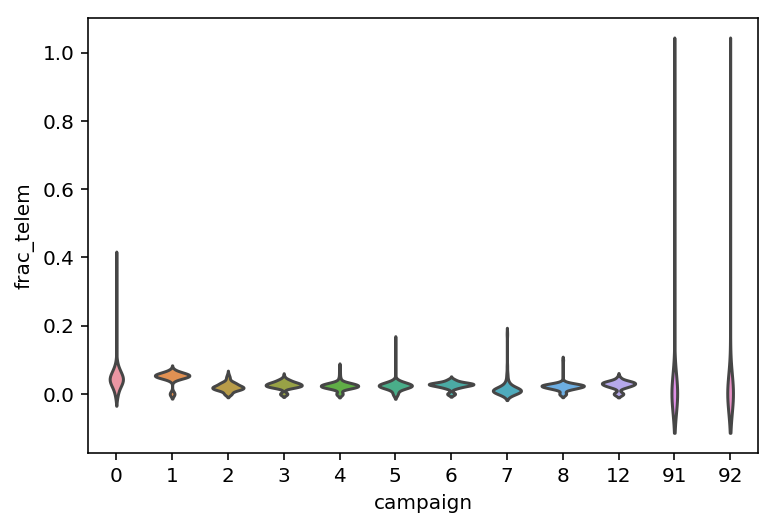

In [22]:
sns.violinplot(x="campaign", y="frac_telem", data=df_all, inner=None)

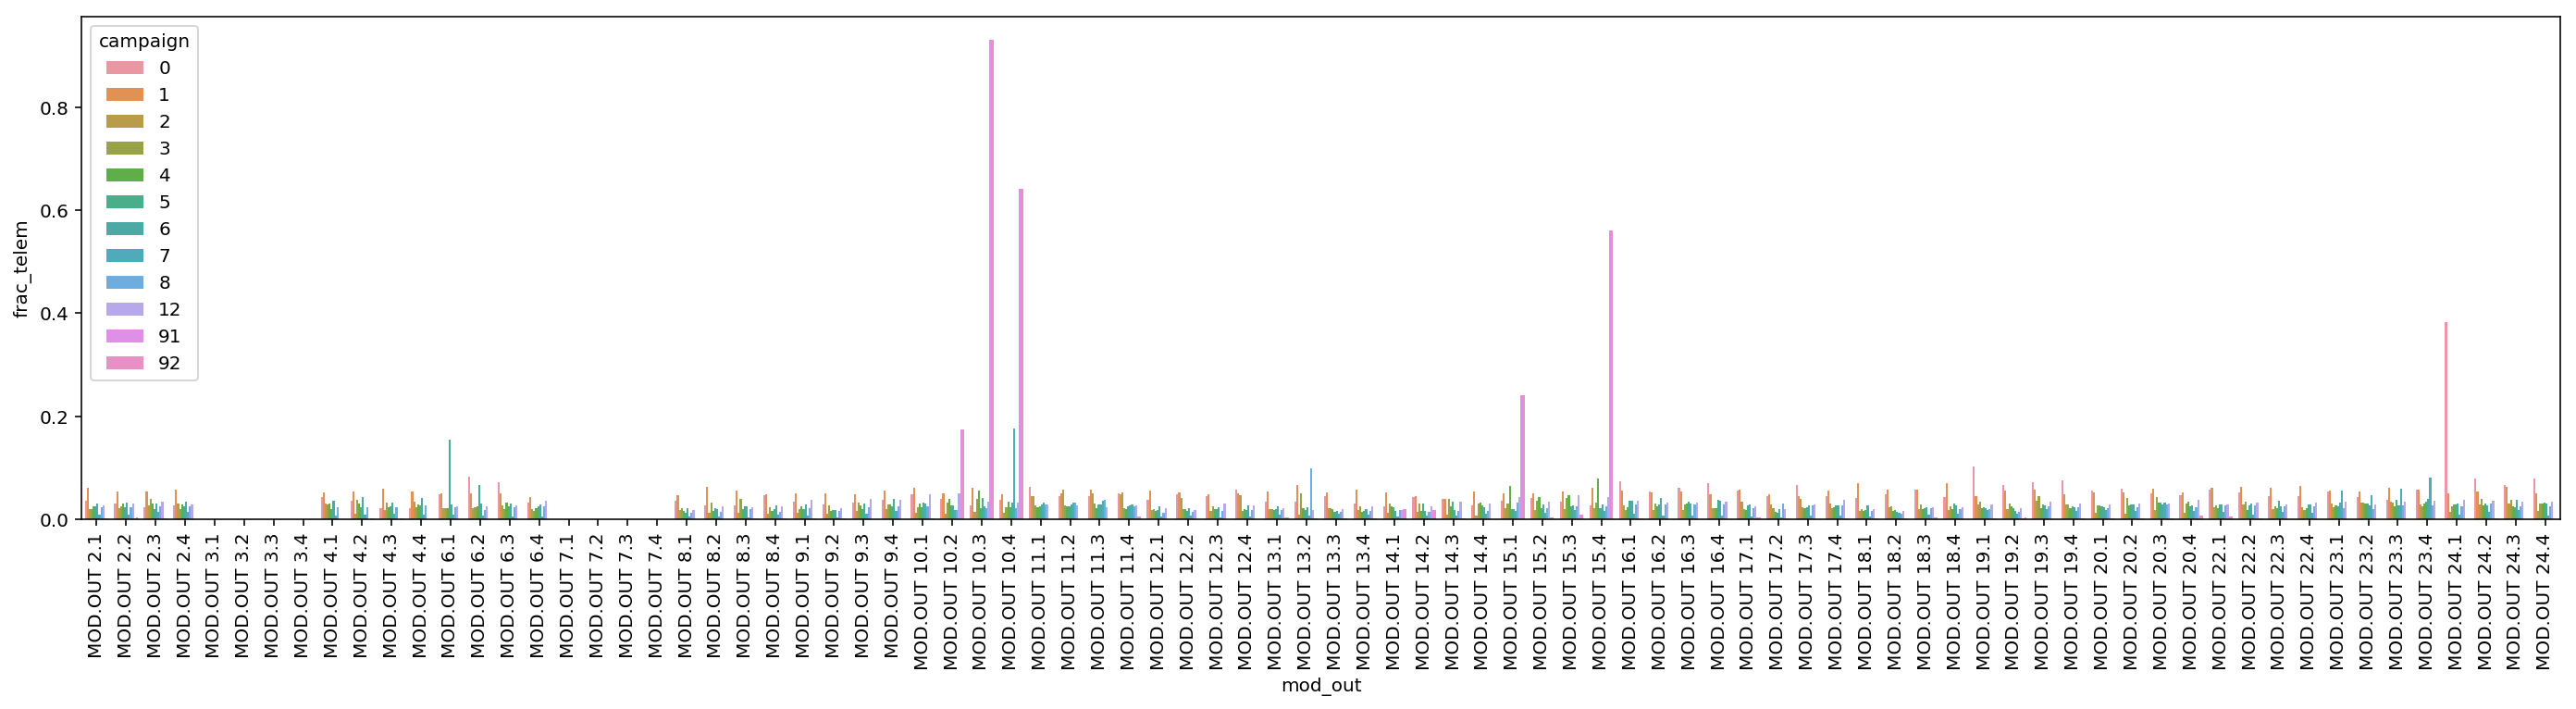

In [23]:
plt.figure(figsize=(24, 5))
sns.barplot(x="mod_out", y="frac_telem", hue='campaign', data=df_all);
plt.xticks(rotation='vertical');

Some campaigns have have a large fraction of their telemetered pixels concentrated in a single module.

In [24]:
df_all.columns

Index(['campaign', 'mod_out', 'n0', 'n1', 'n2', 'n3', 'n4', 'ngt5',
       'telemetered', 'total_pix', 'frac_telem'],
      dtype='object')

In [26]:
by_campaign = df_all.groupby('campaign').sum().drop('frac_telem', axis=1)

Percentage of pixels telemetered by campaign.  There are a few reasons why 

In [27]:
to_plot = by_campaign.telemetered/by_campaign.total_pix*100.0
to_plot = to_plot.to_frame().reset_index().rename(columns={0:'Percent Telemetered'})

Let's see if we get the same answer by counting up the `npix` in the **K2-Target-Index**.  I think we'll have to ignore the short cadence, since those are automatically double counted as long cadence.  We expect the value from the K2-Target-Index to be *over-estimated*, since it double counts overlapping TPFs.

In [28]:
bi = df.index[df.obsmode =='short cadence']
to_plot2 = 100.0*df.drop(bi).groupby('campaign').npix.sum()/101744160
to_plot2 = to_plot2.to_frame().reset_index().rename(columns={'npix':'Percent Telemetered'})

In [29]:
df_telem = pd.merge(to_plot, to_plot2, how='outer', on='campaign')

In [30]:
df_telem

,campaign,Percent Telemetered_x,Percent Telemetered_y
0,0,4.645706,4.874430
1,1,4.906095,5.076463
2,2,2.086748,2.140224
3,3,2.568763,2.629177
4,4,2.388133,2.445873
5,5,2.453314,2.508829
6,6,2.543580,2.608189
7,7,1.552970,1.589788
8,8,2.158745,2.224584
9,12,2.593082,2.647378


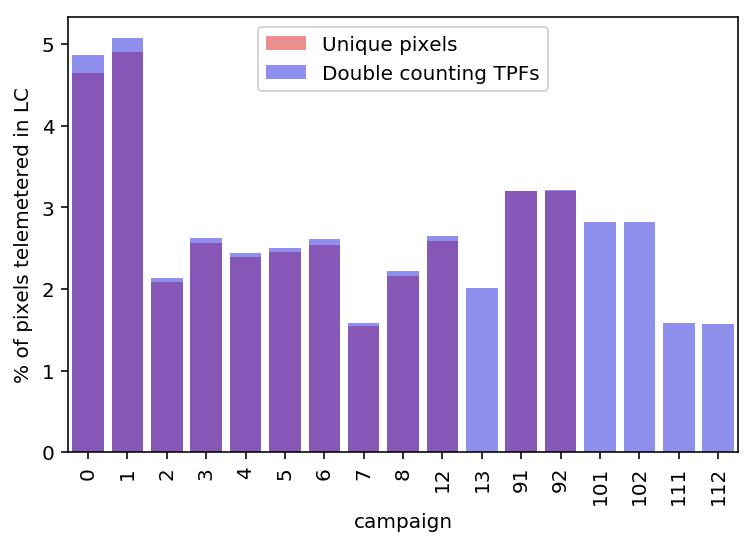

In [37]:
sns.barplot(data=df_telem, y='Percent Telemetered_x', x='campaign', color='r', label='Unique pixels', alpha=0.5)
sns.barplot(data=df_telem, y='Percent Telemetered_y', x='campaign', color='b', label='Double counting TPFs', alpha=0.5)
plt.ylabel('% of pixels telemetered in LC');
plt.legend(loc='best');
plt.savefig('../figures/telemetered_pixel_fraction.png', dpi=300)
plt.xticks(rotation='vertical');

Indeed, that's what we see, double-counting the TPFs slightly overestimates how many pixels you actually telemetered back.  We're missing information for some of the later campaigns (we said we'd sort that our later, remember?)  There are several reasons why a campaign may have more-or-less pixels telemetered, the number of short cadence pixels being chief among them.  I also might not have counted all the TPFs when doing my FFI count analysis (remember there is a log of failed TPFs).  Another factor is the inefficiency of double- or triple- counting overlapping TPFs.  Let's ignore the other problems for now and try to quantify that inefficiency.

In [32]:
by_campaign['extra'] = (by_campaign.n2*2 + 
                        by_campaign.n3*3 +
                        by_campaign.n4*4 +
                        by_campaign.ngt5*5)

In [34]:
by_campaign.extra/(by_campaign.n1+by_campaign.extra)*100.0

campaign
0     9.375987
1     8.098155
2     6.925090
3     7.477048
4     7.485286
5     5.634037
6     6.761224
7     6.264007
8     9.188023
12    6.224726
91    0.555881
92    0.569927
dtype: float64

Hmmm, doesn't seem to jive with the plot above, no?  Maybe something is off with the way I count short cadence.

In [42]:
(df_telem['Percent Telemetered_y']-df_telem['Percent Telemetered_x'])/df_telem['Percent Telemetered_x']*100.0

0     4.923335
1     3.472589
2     2.562662
3     2.351882
4     2.417785
5     2.262846
6     2.540086
7     2.370802
8     3.049858
9     2.093878
10    0.209350
11    0.214184
12         NaN
13         NaN
14         NaN
15         NaN
16         NaN
dtype: float64

Hmm, two different answers!